# Tutorial 3: Imputation scATAC-seq analysis

Here we will use scATAC-seq dataset `Forebrain' as an example to illustrate how scAGDE performs imputation task in scATAC-seq analysis.

## 1. Read and preprocess data

We first read '.h5ad' data file using [Scanpy](https://github.com/scverse/scanpy) package

In [4]:
import scanpy as sc
adata = sc.read_h5ad("data/Forebrain.h5ad")

We can use Scanpy to further filter data. In our case, we pass this step because the loaded dataset has been preprocessed. Some codes for filtering are copied below for easy reference:

In [5]:
sc.pp.filter_cells(adata, min_genes=100)
min_cells = int(adata.shape[0] * 0.01)
sc.pp.filter_genes(adata, min_cells=min_cells)

In [6]:
adata

AnnData object with n_obs × n_vars = 2088 × 11285
    obs: 'celltype', 'n_genes'
    var: 'n_cells'
    uns: 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## 2. Setup and train scAGDE model

Now we can initialize the trainer with the AnnData object, which will ensure settings for model are in place for training. 

We can specify the `outdir` to the dir path where we want to save the output file (mainly the model weights file).

`n_centroids` represents the cluster number of dataset. If this information is unknown, we can set `n_centroids=None` and in this case, scAGDE will apply the estimation strategy to estimate the optimal cluster number for the initialization of its cluster layer. Here, we set `n_centroids=8`.
 
We can train scAGDE on specified device by setting `gpu`. For example, train scAGDE on CPUs by `gpu=None` and trian it on GPU #0 by `gpu="0"`

<div class='alert alert-block alert-info'>
If you are merely interested in learning cell embeddings without consiering any optimization about cell clustering, you can specify `cluster_opt=False` here. In this case, scAGDE will be run withour any clustering-related module and optimization.
 </div>

In [7]:
import scAGDE
trainer = scAGDE.Trainer(adata,outdir="output",n_centroids=8,gpu="3")

device used: cuda:3



Now we can train scAGDE model in end-to-end style. The whole pipeline behind the function of `fit()` mainly consists of three stages, as below:

1. scAGDE first trained an chromatin accessibility-based autoencoder to measure the importance of the peaks and select the key peaks. The number of selected peaks is set to 10,000 in default, or you can change it by setting `top_n`. In the meanwhile, the initial cell representations for cell graph construction are stored in `adata.obs[embed_init_key]`, which is `"latent_init"` in default.

2. scAGDE then constructed cell graph and trains the GCN-based embedded model to  extract essential structural information from both count and cell graph data.

3. scAGDE finally yiels robust and discriminative cell embeddings which are stored in `adata.obsm[embed_key]`, which is `"latent"` in default. Also, scAGDE enables imputation task if `impute_key` is not None and the imputed data will be stored in `adata.obsm[impute_key]`, which is `"impute"` in default. 

scAGDE performs clustering on final embeddings if `cluster_key` is not None, and the cluster assignments will be in `adata.obs[cluster_key]`, which is `"cluster"` in default. The cluster number is the value of `n_centroids` and if estimation is used, the cluster number is the value of estimated cluster number.

You can also explore each step as you wish by following a step-by-step tutorial in [Tutorial 2: Step-by-Step scATAC-seq analysis](./Tutorial%202:%20Step-by-Step%20scATAC-seq%20analysis.ipynb).

In [8]:
adata = trainer.fit(topn=10000,impute_key="impute")
print(adata)

Cell number: 2088
Peak number: 11285
n_centroids: 8


## Training CountModel ##


CountModel: 100%|██████████| 5000/5000 [00:31<00:00, 157.84it/s, loss=1687.1017]



## Constructing Cell Graph ##
Cell number: 2088
Peak number: 10000
n_centroids: 8


## Training GraphModel ##


GraphModel: 100%|██████████| 4000/4000 [00:50<00:00, 78.97it/s, loss=4249.9907]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



AnnData object with n_obs × n_vars = 2088 × 11285
    obs: 'celltype', 'n_genes', 'cluster'
    var: 'n_cells', 'is_selected'
    uns: 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'latent_init', 'impute', 'latent'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


## 3. The imputation visualization

In our study of scAGDE, we evaluated the effectiveness of imputation in multiple ways, like cell clustering and visualization, and explored the impact in downstream analysis. Here we list some key steps for these analysis. 

<div class='alert alert-block alert-warning'>
It is worth noting that the main figures presented in our work were produced by R code, and the general idea is shown here.
 </div>

### 3.1 Fetch imputed data

We can fetch impued data matrix from `adata.obsm[impute_key]`. Also we prepare the original data matrix for comparison.

In [9]:
# subset the adata with selected features
raw = adata[:,adata.var["is_selected"] == 1].X
imputed = adata.obsm["impute"]
print(imputed.shape)
assert imputed.shape == raw.shape, "shape not identical"

(2088, 10000)


Next let's binary the imputed data.

In [10]:
binary = scAGDE.utils.binarization(imputed,raw)
print(binary.shape)

(2088, 10000)


### 3.2 t-SNE/UMAP comparison

We can observe the t-SNE or UMAP visualization on raw, imputed and binary imputed data with cell type labels to evaluate the effect of imputation. Besides, we perform Leiden clustering algorithm for further evaluation.

In [11]:
import warnings
warnings.filterwarnings('ignore')

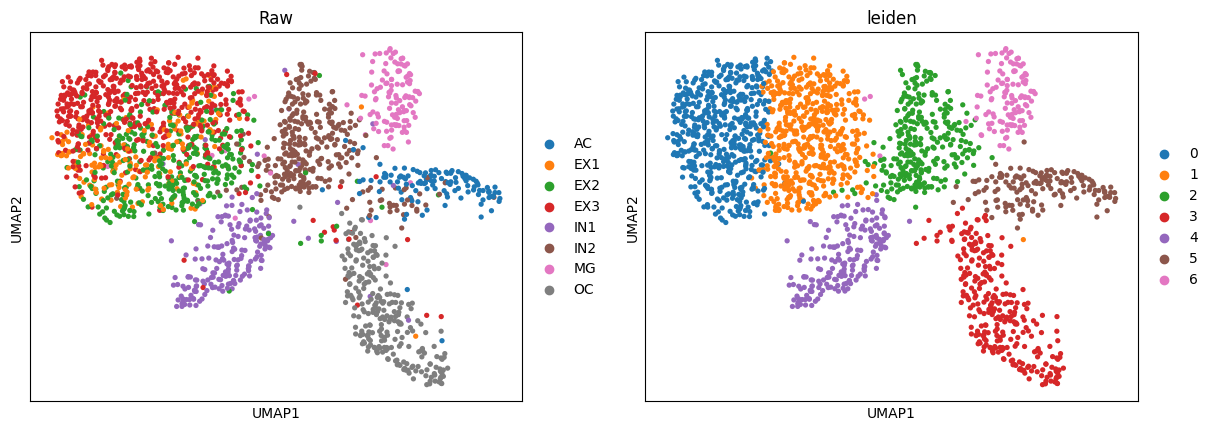

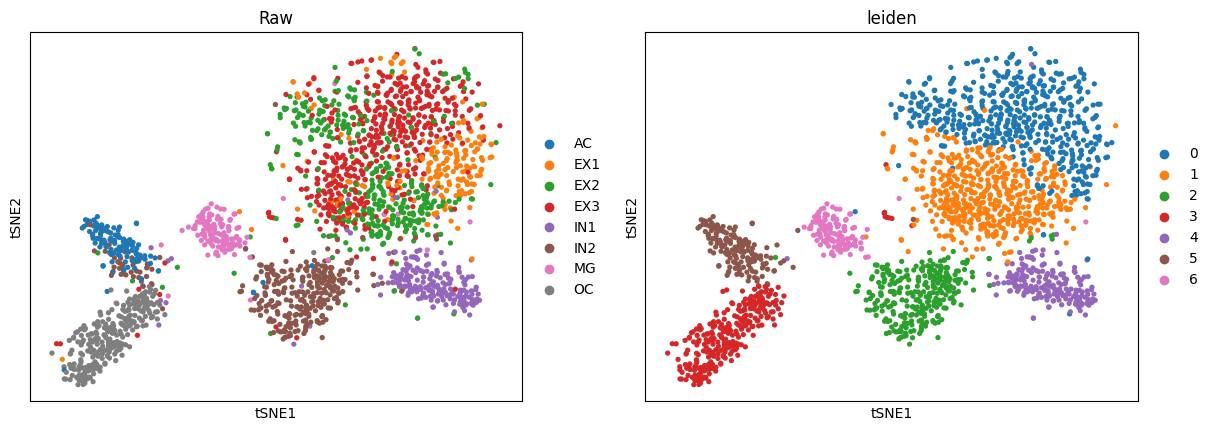

In [12]:
import anndata
data_raw = anndata.AnnData(raw,obs=adata.obs,var=adata[:,adata.var["is_selected"] == 1].var)
sc.tl.pca(data_raw, svd_solver="arpack")
sc.pp.neighbors(data_raw)
sc.tl.umap(data_raw)
sc.tl.tsne(data_raw)
sc.tl.leiden(
    data_raw,
    resolution=0.5,
    random_state=0,
    n_iterations=2,
    directed=False,
)
sc.pl.umap(data_raw,color=["celltype","leiden"],title="Raw")
sc.pl.tsne(data_raw,color=["celltype","leiden"],title="Raw")

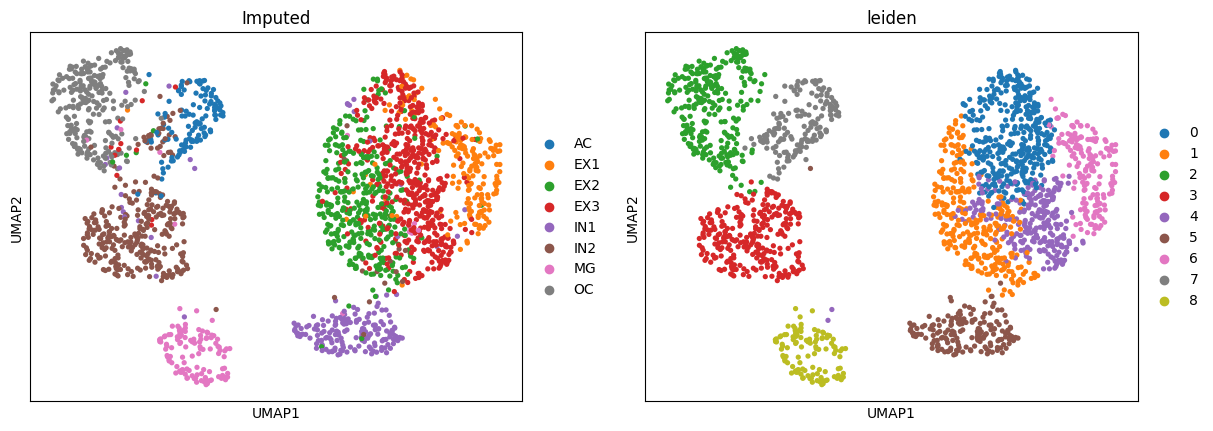

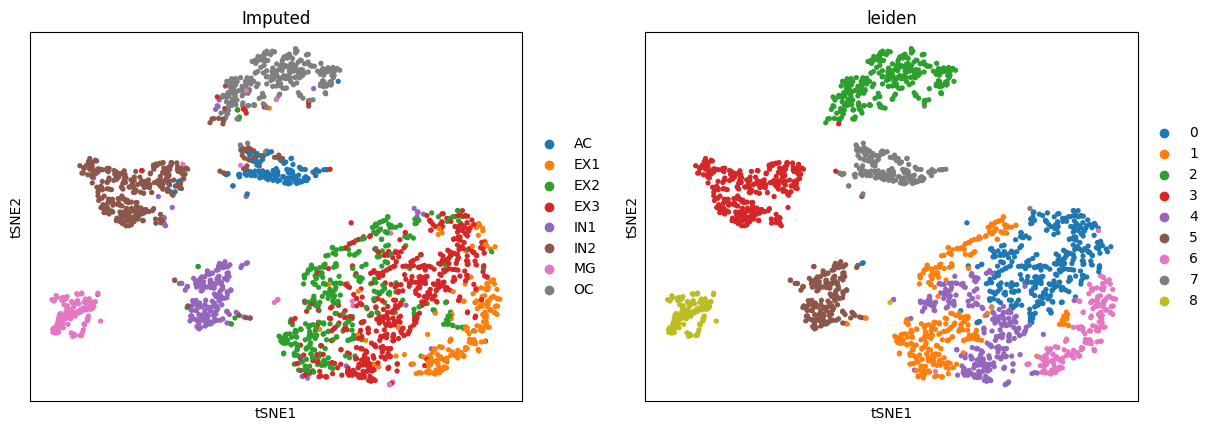

In [13]:
data_imputed = anndata.AnnData(imputed,obs=adata.obs,var=adata[:,adata.var["is_selected"] == 1].var)
sc.tl.pca(data_imputed, svd_solver="arpack")
sc.pp.neighbors(data_imputed)
sc.tl.umap(data_imputed)
sc.tl.tsne(data_imputed)
sc.tl.leiden(
    data_imputed,
    resolution=0.5,
    random_state=0,
    n_iterations=2,
    directed=False,
)
sc.pl.umap(data_imputed,color=["celltype","leiden"],title="Imputed")
sc.pl.tsne(data_imputed,color=["celltype","leiden"],title="Imputed")

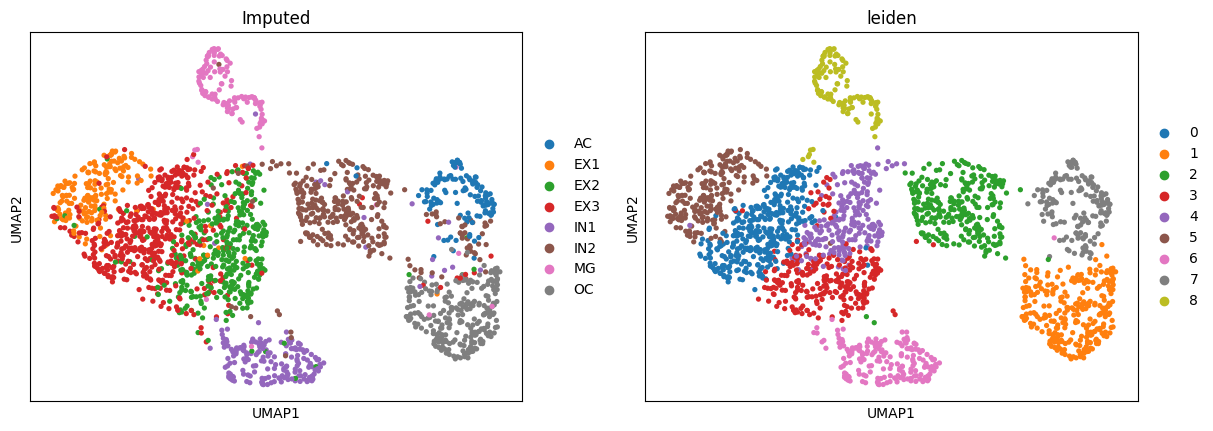

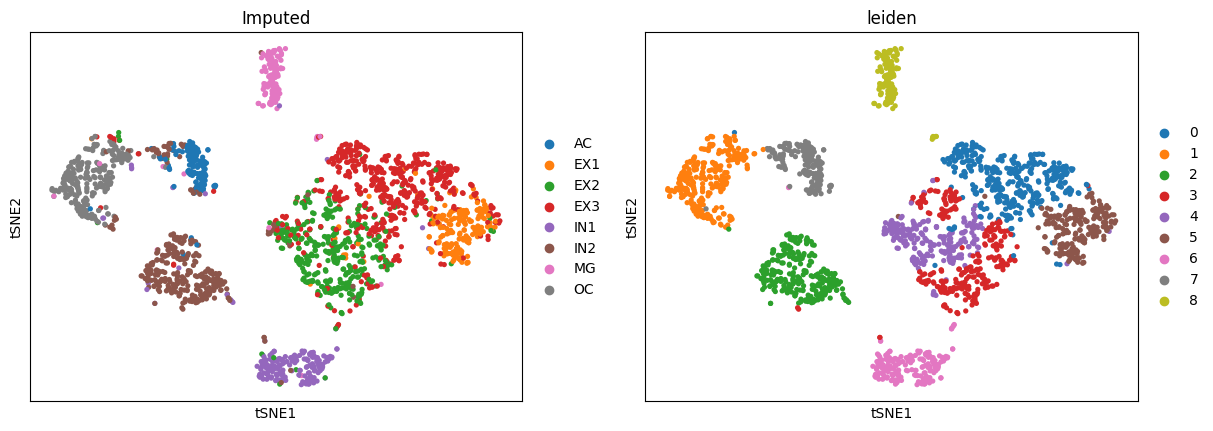

In [14]:
data_binary = anndata.AnnData(binary.A,obs=adata.obs,var=adata[:,adata.var["is_selected"] == 1].var)
sc.tl.pca(data_binary, svd_solver="arpack")
sc.pp.neighbors(data_binary)
sc.tl.tsne(data_binary)
sc.tl.umap(data_binary)
sc.tl.leiden(
    data_binary,
    resolution=0.5,
    random_state=0,
    n_iterations=2,
    directed=False,
)
sc.pl.umap(data_binary,color=["celltype","leiden"],title="Imputed")
sc.pl.tsne(data_binary,color=["celltype","leiden"],title="Imputed")

Finally, we save the `AnnData` object in `.h5ad` format, including the binarized imputed data for future use.

In [ ]:
# 
import os
# Generate Seurat object
outdir = "imputation"
if not os.path.exists(outdir): os.makedirs(outdir)
# We save the binary imputed data into the AnnData object for future use.
adata.obsm["binary"] = binary.A
adata[:,adata.var["is_selected"] == 1].write(os.path.join(outdir,"brain.h5ad"),compression="gzip")

## 3. Downstream analysis

### 3.1 Set up the enviornment and data 

- ***How to use R code in this notebook?***

We have developed several R scripts to perform downstream analyses, and the essential code for key analyses is provided below. To interactively execute the analysis within this notebook, we utilize the [rpy2](https://github.com/rpy2/rpy2) package, which allows running R code directly. Thus, please ensure that rpy2 is installed. Alternatively, you may extract these R scripts and execute them externally as standalone R scripts. 

The code below initializes rpy2. After this setup, you can write and execute R code directly within notebook cells by starting with `%%R`.

In [2]:
import logging
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
%load_ext rpy2.ipython

To completely finish the following analysis, you need requires specific R packages listed below (`pkgs`), and you can verify and install using the code provided below.

The following code will help you install all the required packages:\
% Installing with conda solves most of the dependency package installation problems: \
conda install r-signac\
conda install r-seurat\
conda install r-sceasy\
conda install bioconductor-tfbstools\
% The other packages can be installed just in R: \
install.packages("reticulate")\
install.packages("dplyr")\
if (!requireNamespace("BiocManager", quietly = TRUE))  install.packages("BiocManager")\
BiocManager::install("ComplexHeatmap")\
BiocManager::install("JASPAR2020")\
BiocManager::install("EnsDb.Mmusculus.v79")\
BiocManager::install("BSgenome.Mmusculus.UCSC.mm10")\
BiocManager::install("biovizBase")\
BiocManager::install("motifmatchr")\
BiocManager::install("chromVAR")

In [3]:
%%R
pkgs <- c(
    "reticulate",
    "sceasy",
    "Signac",
    "Seurat",
    "dplyr",
    "ComplexHeatmap",
    "ggplot2",
    "circlize",
    "TFBSTools",
    "JASPAR2020",
    "EnsDb.Mmusculus.v79",
    "BSgenome.Mmusculus.UCSC.mm10"
)
######## Install all packages using codes below ########
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install(pkgs)
suppressWarnings(suppressPackageStartupMessages(lapply(pkgs,library,character.only=TRUE)))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    [[1]]
[1] "reticulate" "tools"      "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[2]]
 [1] "sceasy"     "reticulate" "tools"      "stats"      "graphics"  
 [6] "grDevices"  "utils"      "datasets"   "methods"    "base"      

[[3]]
 [1] "Signac"     "sceasy"     "reticulate" "tools"      "stats"     
 [6] "graphics"   "grDevices"  "utils"      "datasets"   "methods"   
[11] "base"      

[[4]]
 [1] "SeuratObject" "Seurat"       "Signac"       "sceasy"       "reticulate"  
 [6] "tools"        "stats"        "graphics"     "grDevices"    "utils"       
[11] "datasets"     "methods"      "base"        

[[5]]
 [1] "dplyr"        "SeuratObject" "Seurat"       "Signac"       "sceasy"      
 [6] "reticulate"   "tools"        "stats"        "graphics

- ***How to read AnnData data object in R?***

First, we will convert Python objects into data formats required by R. Specifically, we will convert an `AnnData` object to a Seurat object and save it as an `.rds` file. Here, we use the `sceasy` package to perform this task; however, you may opt for any other method you are comfortable with.

In [24]:
%%R
sceasy::convertFormat("imputation/brain.h5ad", from = "anndata", to = "seurat", outFile = "imputation/brain.rds", assay="peaks")

An object of class Seurat 
10000 features across 2088 samples within 1 assay 
Active assay: peaks (10000 features, 0 variable features)
 2 layers present: counts, data
 7 dimensional reductions calculated: pca, tsne, umap, binary, impute, latent, latent_init


X -> counts


Next, let we example the correct data object in R.

In [34]:
%%R
brain <- readRDS("imputation/brain.rds")
brain

An object of class Seurat 
10000 features across 2088 samples within 1 assay 
Active assay: peaks (10000 features, 0 variable features)
 2 layers present: counts, data
 7 dimensional reductions calculated: pca, tsne, umap, binary, impute, latent, latent_init


### 3.2 Differential accessibility regions (DARs) identification

Next, let’s identify Differential Accessibility Regions following the standard [Signac workflow](https://stuartlab.org/signac/articles/mouse_brain_vignette). First, we need to convert the data to the appropriate format. During this process, we will integrate both the imputed and binary imputed data as two `ChromatinAssay` objects within the same `SeuratObject`, storing them as different `assay`.

- ***Prepare data object***

In [35]:
%%R
library(Signac)
library(EnsDb.Mmusculus.v79)
# Convert our Seurat object to Signac object, saving meta information and cell embeddings.
metadata <- brain@meta.data
latent <- brain@reductions$latent
latent@assay.used <- "peaks"
counts_ <- brain@assays$peaks@counts
impute_ <- t(brain@reductions$impute@cell.embeddings)
rownames(impute_) <- rownames(brain)
binary_ <- t(brain@reductions$binary@cell.embeddings)
rownames(binary_) <- rownames(brain)
chrom_assay <-  CreateChromatinAssay(
  counts = counts_,
  sep = c(":", "-")
)
brain <- CreateSeuratObject(
  counts = chrom_assay,
  assay = 'peaks',
  meta.data = metadata
)
brain[["latent"]] <- latent
brain[["impute"]] <-  CreateChromatinAssay(
  counts = impute_,
  sep = c("-", "-")
)
brain[["binary"]] <-  CreateChromatinAssay(
  counts = binary_,
  sep = c("-", "-")
)
Idents(brain) <- brain$celltype
# Annotation
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "mm10"
# saveRDS("imputation/annotation.rds",annotations)
# annotations <- readRDS("imputation/annotation.rds")
Annotation(brain[["peaks"]]) <- annotations
Annotation(brain[["impute"]]) <- annotations
Annotation(brain[["binary"]]) <- annotations
rm(counts_,impute_,binary_,annotations,chrom_assay,latent,metadata)

- ***DARs identification***

At this stage, we use the `FindAllMarkers` function to identify differential accessible regions for the raw, imputed, and binary imputed data separately.

In [36]:
%%R
markersPeaks.Raw <- FindAllMarkers(brain, only.pos = TRUE, min.pct = 0.15, logfc.threshold = 0.15,assay = "peaks")
markersPeaks.Impute <- FindAllMarkers(brain, only.pos = TRUE, min.pct = 0.15, logfc.threshold = 0.15,assay = "impute")
markersPeaks.Binary <- FindAllMarkers(brain, only.pos = TRUE, min.pct = 0.15, logfc.threshold = 0.15,assay = "binary")

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~17s           |++                                                | 2 % ~17s           |++                                                | 3 % ~17s           |+++                                               | 4 % ~17s           |+++                                               | 5 % ~17s           |++++                                              | 6 % ~16s           |++++                                              | 7 % ~16s           |+++++                                             | 8 % ~16s           |+++++                                             | 9 % ~16s           |++++++                                            | 10% ~16s           |++++++                                            | 11% ~16s           |+++++++                                           | 12% ~15s           |+++++++                                           | 13% ~15s 

Calculating cluster AC
Calculating cluster EX1
Calculating cluster EX2
Calculating cluster EX3
Calculating cluster IN1
Calculating cluster IN2
Calculating cluster MG
Calculating cluster OC


In [4]:
%%R
# saveRDS(object = markersPeaks.Raw,file = "imputation/markersPeaks.Raw.rds")
# saveRDS(object = markersPeaks.Impute,file = "imputation/markersPeaks.Impute.rds")
# saveRDS(object = markersPeaks.Binary,file = "imputation/markersPeaks.Binary.rds")
# markersPeaks.Raw <- readRDS("imputation/markersPeaks.Raw.rds")
# markersPeaks.Impute <- readRDS("imputation/markersPeaks.Impute.rds")
# markersPeaks.Binary <- readRDS("imputation/markersPeaks.Binary.rds")


Select the top 15 most prominent differentially accessible regions for each cluster.

In [36]:
%%R
markersPeaks.topn.Raw <- markersPeaks.Raw %>%
  group_by(cluster) %>%
  top_n(n = 15, wt = avg_log2FC)
markersPeaks.topn.Impute <- markersPeaks.Impute %>%
  group_by(cluster) %>%
  top_n(n = 15, wt = avg_log2FC)
markersPeaks.topn.Binary <- markersPeaks.Binary %>%
  group_by(cluster) %>%
  top_n(n = 15, wt = avg_log2FC)


- ***Heatmap visualization***

The following code uses the [ComplexHeatmap](https://github.com/jokergoo/ComplexHeatmap) package to plot accessibility heatmaps for the three data matrices across these top DARs.

In [49]:
%%R
library(dplyr)
library(ComplexHeatmap)
library(circlize)
solarExtra = c("5"='#3361A5', "7"='#248AF3', "1"='#14B3FF', "8"='#88CEEF', "9"='#C1D5DC', "4"='#EAD397', "3"='#FDB31A',"2"= '#E42A2A', "6"='#A31D1D')  
paletteContinuous <- function(
    pal, 
    n = 256, 
    reverse = FALSE
){
  palOut <- colorRampPalette(pal)(n)
  return(palOut)
  
}
.rowZscores <- function(m = NULL, min = -2, max = 2, limit = FALSE){
  z <- sweep(m - rowMeans(m), 1, matrixStats::rowSds(m),`/`)
  if(limit){
    z[z > max] <- max
    z[z < min] <- min
  }
  return(z)
}
hm <- function(mat,sp){
  mat <- .rowZscores(mat, limit = FALSE)
  limits = c(min(mat), max(mat))
  color = paletteContinuous(solarExtra, n = 100)
  breaks <- seq(-2,2, length.out = length(color))
  color <- circlize::colorRamp2(breaks, color)
  top_anno <- HeatmapAnnotation(
    cluster = anno_block(gp = gpar(fill = NA,col=NA), # set color
                         labels = levels(cluster_info), 
                         labels_gp = gpar(cex = 0.5, col ="black",fontsize=25, fontface="bold"))) # set font
  Heatmap(
    mat,
    name = "Z-score",
    cluster_rows = FALSE,
    cluster_columns = FALSE,
    show_column_names = FALSE,
    show_row_names = FALSE,
    column_split = cluster_info,
    row_split = sp,
    border = T,
    border_gp = gpar(lwd=1,col="#555555"),
    # row_split = cluster_info,
    top_annotation =  top_anno, 
    # left_annotation =  top_anno, 
    column_title= NULL,
    row_title = NULL,
    col = color,
    heatmap_legend_param = list(
      color_bar = "continuous", 
      legend_direction = "horizontal"
    )
  )
}

# Fetching data for heatmap plots
cluster_info <- sort(brain$celltype)
mat.raw <- GetAssayData(brain, slot = "data", assay = "peaks")
mat.raw <- as.matrix(mat.raw[markersPeaks.topn.Raw$gene, names(cluster_info)])
mat.impute <- GetAssayData(brain, slot = "data", assay = "impute")
mat.impute <- as.matrix(mat.impute[markersPeaks.topn.Impute$gene, names(cluster_info)])
mat.binary <- GetAssayData(brain, slot = "data", assay = "binary")
mat.binary <- as.matrix(mat.binary[markersPeaks.topn.Binary$gene, names(cluster_info)])


Let's show the heatmaps for raw, imputed and binary imputed data in that order:

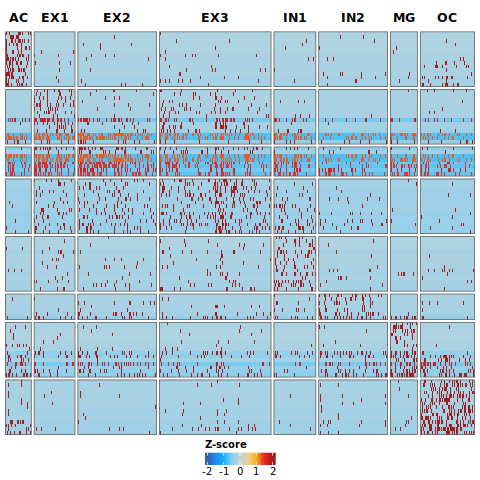

In [93]:
%%R
ht_opt$message = FALSE
# pdf("imputation/heatmap_DARs_raw.pdf", width = 8, height = 4.5)
draw(hm(mat.raw,markersPeaks.topn.Raw$cluster),heatmap_legend_side = "bot",)
# dev.off()

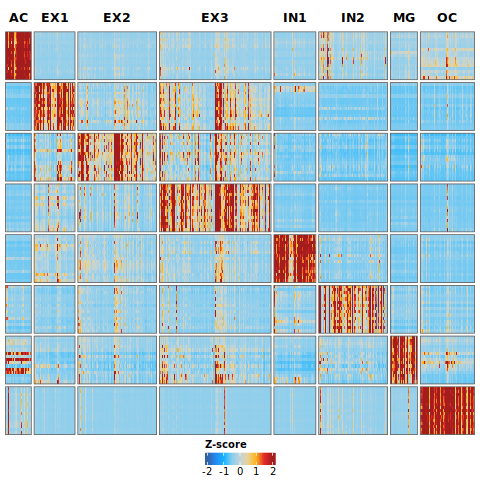

In [94]:
%%R
# pdf("imputation/heatmap_DARs_impute.pdf", width = 8, height = 4.5)
draw(hm(mat.impute,markersPeaks.topn.Impute$cluster),heatmap_legend_side = "bot")
# dev.off()

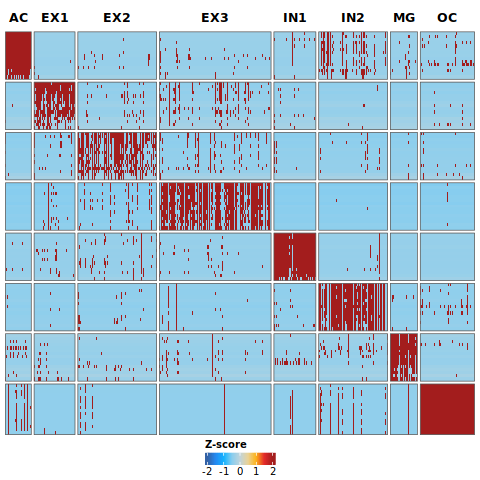

In [95]:
%%R
# pdf("imputation/heatmap_DARs_binary.pdf", width = 8, height = 4.5)
draw(hm(mat.binary,markersPeaks.topn.Binary$cluster),heatmap_legend_side = "bot")
# dev.off()

- ***Difference sets of DARs***

Next, we investigate how imputation enhances the results of DARs analysis, focusing on the set of differential DARs as the starting point.

In [98]:
%%R
a <- markersPeaks.Impute %>%
  dplyr::filter(avg_log2FC > 1) %>%
  arrange(cluster)
b <- markersPeaks.Raw %>%
  dplyr::filter(avg_log2FC > 1) %>%
  arrange(cluster)
diff.more <- as.data.frame(setdiff(a,b))
diff.more.topn <- diff.more %>%
  group_by(cluster) %>%
  dplyr::filter(avg_log2FC > 1)
mat.diff <- GetAssayData(brain, slot = "data", assay = "impute")
mat.diff <- as.matrix(mat.diff[diff.more.topn$gene, names(cluster_info)])
mat <- mat.diff
.rowZscores(mat, limit = FALSE)-> mat


Let's visualize the heatmap on these difference sets of DARs.

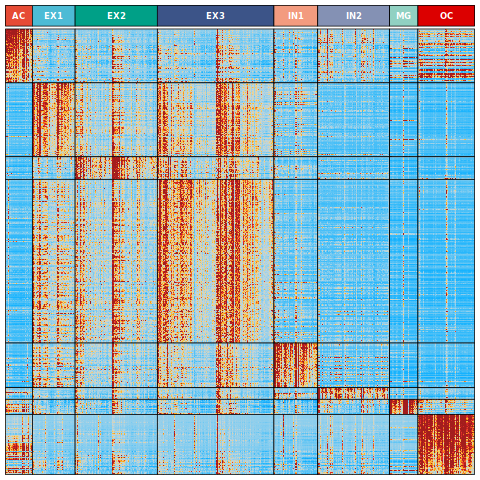

In [105]:
%%R
color.count = paletteContinuous(solarExtra, n = 100)
breaks <- seq(-2, 2, length.out = length(color.count))
color.count <- circlize::colorRamp2(breaks, color.count)
top_anno <- HeatmapAnnotation(
  cluster = anno_block(gp = gpar(fill = c("#E64B35FF","#4DBBD5FF","#00A087FF","#3C5488FF","#F39B7FFF","#8491B4FF","#91D1C2FF","#DC0000FF")), # 设置填充色
                       labels = levels(cluster_info), 
                       labels_gp = gpar(cex = 0.5, col = "white",fontsize=17,fontface="bold"))) # set font
sp <- subset(diff.more.topn,select=c("gene","cluster"))
sp$gene <- NULL


hm.count <- Heatmap(
  mat,
  name = "Z-score",
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  show_column_names = FALSE,
  show_row_names = FALSE,
  column_split = cluster_info,
  top_annotation =  top_anno,
  column_title= NULL,
  col = color.count,
  split = sp,
  row_title = NULL,
  row_gap = unit(0, "mm"),
  column_gap = unit(0, "mm"),
  border = TRUE,
  border_gp = gpar(lwd=1),
  heatmap_legend_param = list(
    color_bar = "continuous", 
    legend_direction = "horizontal"
  )
)
draw(hm.count,gap=unit(0, "points"),heatmap_legend_side = "bot",show_heatmap_legend=F)

### 3.3 Motif deviation score

To further understand the biological significance behind this increase in cell type-specific peaks post-imputation, we proceeded with enrichment analysis. The analysis revealed that the enhanced cell type-specific peaks after imputation are significantly associated with cell identity, rather than being arbitrary occurrences.

Specifically, we use `Signac` which has incorporated `chromVAR` algorithm to calculate the motif activity score for each cell. For a detailed explanation of the method, refer to the Signac or chromVAR paper.

- ***Calculate motif deviation score***

In [37]:
%%R
library(TFBSTools)
library(JASPAR2020)
library(BSgenome.Mmusculus.UCSC.mm10)
genome <- BSgenome.Mmusculus.UCSC.mm10
pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(species=10090,collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)
brain <- AddMotifs(object = brain,genome = genome,pfm = pfm)
motif.id2name <- lapply(pfm,function(x){x@name})
motif.name2id <- setNames(as.list(names(motif.id2name)), unlist(motif.id2name))

Beyond motif deviation score, we also computed T-SNE embedding based on this score for futher visualization.

In [38]:
%%R
brain <- RunChromVAR(
  object = brain,
  genome = genome,
  assay = "peaks",
  new.assay.name = "chromvar.peaks",
)
DefaultAssay(brain) <- "chromvar.peaks"
brain <- ScaleData(brain, features = rownames(brain),do.scale=F)
brain <- RunPCA(brain,slot="data", features = rownames(brain),reduction.name = "pca.chromvar.peaks",reduction.key = "pca.chromvar.peaks")
brain <- RunTSNE(brain,slot="data", reduction = "pca.chromvar.peaks", reduction.name = "tsne.chromvar.peaks",reduction.key = "tsne.chromvar.peaks",check_duplicates=F)

In [39]:
%%R
brain <- AddMotifs(object = brain,genome = genome,pfm = pfm, assay = "impute")
brain <- RunChromVAR(
  object = brain,
  genome = genome,
  assay = "impute",
  new.assay.name = "chromvar.impute",
)
DefaultAssay(brain) <- "chromvar.impute"
brain <- ScaleData(brain, features = rownames(brain),do.scale=F)
brain <- RunPCA(brain,slot="data", features = rownames(brain),reduction.name = "pca.chromvar.impute",reduction.key = "pca.chromvar.impute")
brain <- RunTSNE(brain,slot="data", reduction = "pca.chromvar.impute", reduction.name = "tsne.chromvar.impute",reduction.key = "tsne.chromvar.impute",check_duplicates=F)


- ***Visualize motif deviation scor before and after imputation***

In [ ]:
%%R
# Ensure the existence of interested motif.
grep("Dlx2",names(motif.name2id),ignore.case=T,value=T)

[1] "Dlx2"


In [ ]:
%%R
library(ggplot2)
plotfunction <- function(tf,noTitle=F){
  g <- FeaturePlot(
    object = brain,
    features = as.character(motif.name2id[tf]), # query the corresponding id by motif name.
    min.cutoff = 'q5',
    max.cutoff = 'q95',
    pt.size = 1,
    label = T,
    reduction = "tsne.chromvar.impute",
    # ncol = length(chosen),
    col = paletteContinuous(colorRampPalette(
      c("1"="#8499cb","2"="white","3"="#ff0000")
    )(10), n = 50),
    slot = "data"
  )+
    ggtitle(NULL)+
    labs(x = "TSNE1", y = "TSNE2")+
    theme(
      axis.line = element_line(linewidth=.25,arrow = arrow(type = "closed",length = unit(0.04, "inches"))),
      panel.border = element_blank(),
      axis.text = element_blank(),
      axis.ticks = element_blank(),
      axis.title = element_text(hjust = 0, face = "italic"),
      plot.margin = margin(0,0,0,0)
    )+
    NULL
  g
}
tf <- "Dlx2"
DefaultAssay(brain) <- "chromvar.impute"
p1 <- plotfunction(tf)
DefaultAssay(brain) <- "chromvar.peaks"
p2 <- plotfunction(tf)


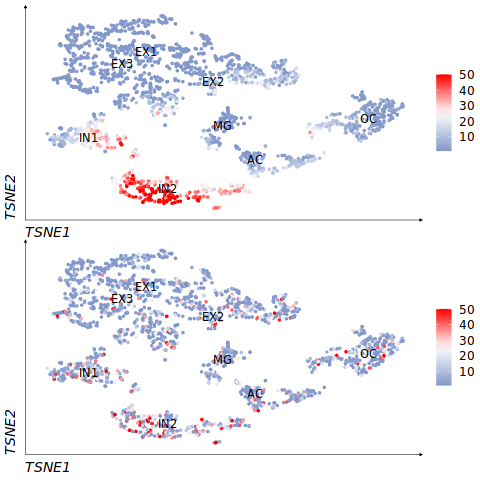

In [ ]:
%%R
# `p1` represents the interest feature's expression of imputed data, while 'p2' represents the result of raw data.
p1/p2

- ***Differential testing on motif score***

To identify cell type-specific regulatory elements, we can search for differentially-active motifs by performing differential testing on motif score.

In [40]:
%%R
markers.dev.peaks <- FindAllMarkers(
  object = brain,
  only.pos = T,
  mean.fxn = rowMeans,
  fc.name = "avg_diff",
  min.pct = .25, logfc.threshold = .25,
  assay = "chromvar.peaks",
  slot = "scale.data"
)
markers.dev.peaks$motif.name <- brain[["peaks"]]@motifs@motif.names[markers.dev.peaks$gene]
markers.dev.impute <- FindAllMarkers(
  object = brain,
  only.pos = T,
  mean.fxn = rowMeans,
  fc.name = "avg_diff",
  min.pct = .25, logfc.threshold = .25,
  assay = "chromvar.impute",
  slot = "scale.data"
)
markers.dev.impute$motif.name <- brain[["peaks"]]@motifs@motif.names[markers.dev.impute$gene]

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++                                       | 21% ~00s           |++++++++++++                                      | 23% ~00s           |+++++++++++++                                     | 25% ~00s 

Select the top 7 most prominent differentially-active motifs for each cluster.

In [44]:
%%R
markers.motif.sig.impute <- markers.dev.impute[which(markers.dev.impute$avg_diff>1),]
markers.motif.sig.peaks <- markers.dev.peaks[which(markers.dev.peaks$avg_diff>1),]

markers.motif.sig.impute.topn <- markers.motif.sig.impute%>%
  group_by(cluster)%>%
  top_n(7,wt = avg_diff)
markers.motif.sig.peaks.topn <- markers.motif.sig.peaks%>%
  group_by(cluster)%>%
  top_n(7,wt = avg_diff)

The following code uses the [ComplexHeatmap](https://github.com/jokergoo/ComplexHeatmap) package to plot accessibility heatmaps for the three data matrices across these top DARs.

In [52]:
%%R
# Fetching data for heatmap plots
mat.dev.impute <- GetAssayData(brain, slot = "data", assay = "chromvar.impute")
mat.dev.impute <- as.matrix(mat.dev.impute[markers.motif.sig.impute.topn$gene, names(cluster_info)])
mat.dev.peaks <- GetAssayData(brain, slot = "data", assay = "chromvar.peaks")
mat.dev.peaks <- as.matrix(mat.dev.peaks[markers.motif.sig.peaks.topn$gene, names(cluster_info)])


top_anno <- HeatmapAnnotation(
  cluster = anno_block(gp = gpar(fill = NA,col=NA), 
                       labels = levels(cluster_info), 
                       labels_gp = gpar(cex = 0.5, col = c("#E64B35FF","#4DBBD5FF","#00A087FF","#3C5488FF","#F39B7FFF","#8491B4FF","#91D1C2FF","#DC0000FF"),fontsize=25, fontface="bold"))) # 设置字体
hm.impute <- Heatmap(
  mat.dev.impute,
  name = "chromVAR deviations of imputed",
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  show_column_names = FALSE,
  column_split = cluster_info,
  top_annotation =  top_anno,
  column_title= NULL,
  col = paletteContinuous(colorRampPalette(
    c("1"="#8499cb","2"="white","3"="#ff0000")
  )(10), n = 100),
  
  row_names_rot = 0,
  row_names_side = "left",
  row_labels = motif.id2name[rownames(mat.dev.impute)],
  row_title = NULL,
  row_gap = unit(0, "mm"),
  column_gap = unit(0, "mm"),
  border = F,
  border_gp = gpar(lwd=1),
  heatmap_legend_param = list(
    color_bar = "continuous", 
    legend_direction = "horizon"
  )
)
hm.raw <- Heatmap(
  mat.dev.peaks,
  name = "chromVAR deviations of raw",
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  show_column_names = FALSE,
  column_split = cluster_info,
  top_annotation =  top_anno,
  column_title= NULL,
  col = paletteContinuous(colorRampPalette(
    c("1"="#8499cb","2"="white","3"="#ff0000")
  )(10), n = 100),
  
  row_names_rot = 0,
  row_names_side = "left",
  row_labels = motif.id2name[rownames(mat.dev.peaks)],
  row_title = NULL,
  row_gap = unit(0, "mm"),
  column_gap = unit(0, "mm"),
  border = F,
  border_gp = gpar(lwd=1),
  heatmap_legend_param = list(
    color_bar = "continuous", 
    legend_direction = "horizon"
  )
)


Let's show the heatmaps for raw, imputed and binary imputed data in that order:

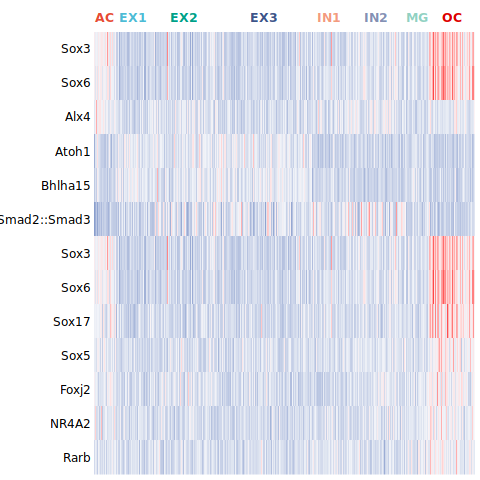

In [53]:
%%R
draw(hm.raw,gap=unit(0, "points"),heatmap_legend_side = "left",show_heatmap_legend=F)

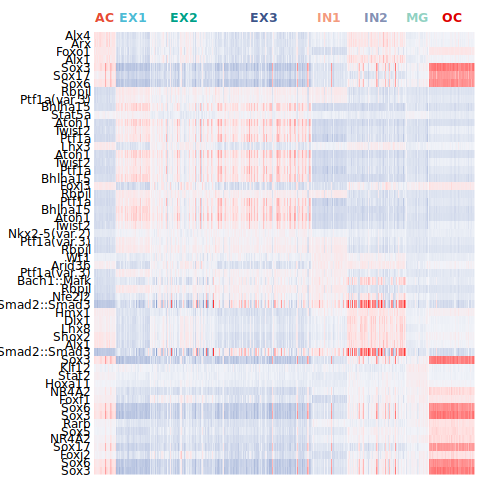

In [54]:
%%R
draw(hm.impute,gap=unit(0, "points"),heatmap_legend_side = "left",show_heatmap_legend=F)

Obviously, the heatmap of top differentially-active motifs based on imputed data provides clearer cell group distribution.